In [64]:
import pandas as pd 
import numpy as np
import scipy
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *
from statsmodels.sandbox.stats.multicomp import multipletests 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, LassoCV, RidgeClassifierCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

import datetime

In [36]:
# откроем файл
data = pd.read_csv('SAMPLE_DATAv1.csv', sep=';', 
                   parse_dates=['order_date'])
data.head()

,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt
0,90,2018-01-31,13002.0,3286542,42,1
1,90,2018-01-31,1001.0,3341612,210,1
2,90,2018-07-02,3019.0,3156604,99,1
3,90,2018-07-02,1002.0,3243437,41,1
4,90,2018-02-14,1011.0,2002127,98,3


In [37]:
# посмотрим на кол-во уникальных значений в признаках
for i in data.columns.to_list():
    print (str(i))
    print (data[i].value_counts())
    print ('\n')

client_ID
91404780    172
91169054    152
584750      148
812703      141
91065339    131
           ... 
91554233      1
91360559      1
91127918      1
91704764      1
91568214      1
Name: client_ID, Length: 4692, dtype: int64


order_date
2018-07-02    358
2018-04-04    327
2018-02-19    324
2018-03-02    309
2018-01-03    300
             ... 
2017-11-01      5
2017-12-02      5
2017-01-23      4
2018-01-01      3
2017-12-31      3
Name: order_date, Length: 665, dtype: int64


LVL2_ID
1010.0     10701
1011.0      9060
1014.0      6464
1012.0      3492
1004.0      2928
           ...  
32017.0        1
32018.0        1
10006.0        1
11008.0        1
13010.0        1
Name: LVL2_ID, Length: 121, dtype: int64


product_ID
2013264    323
2013197    319
3186418    287
3139357    275
2002127    259
          ... 
3315775      1
3356266      1
3343980      1
3348078      1
3140523      1
Name: product_ID, Length: 16384, dtype: int64


sum_rub
99      618
0       515
90      471
70     

In [38]:
# проверим, есть ли в признаках неизвестные
col_with_mis_vals = data.columns[data.isnull().sum() > 0].to_list()
print ('Категории с неизвестными значениями: ' + str(col_with_mis_vals))

Категории с неизвестными значениями: ['LVL2_ID']


In [39]:
# проверим, вдруг у товара с неизвестной категорией категория известна в другой строке?
products_noncat = data.loc[data.LVL2_ID.isnull(), 'product_ID'].unique()
print (data.loc[data['product_ID'].isin(products_noncat), :])

       client_ID order_date  LVL2_ID  product_ID  sum_rub  sum_cnt
10681     957531 2018-10-09      NaN     3219270       77        1
11717    1015218 2017-01-05      NaN     3320548        0        1
17952   91004632 2018-05-04      NaN     3344260       85        2
17972   91004632 2018-10-19      NaN     3344260       79        2
22691   91056336 2018-08-28      NaN     3344259       42        1
27582   91119912 2018-03-29      NaN     3344259       42        1
36655   91276020 2018-03-24      NaN     3320996      169        1
37616   91293189 2018-10-07      NaN     3344261       42        1
43192   91384158 2018-02-27      NaN     3321007      199        1
64311   91699576 2017-04-25      NaN     3320548        0        1


In [40]:
# у товаров с неизвестной категорией категория неизвестна во всех случаях, где встречаются эти товары, 
# поэтому заменим ее на новый индекс (стоящий перед наименьшим)
print ('Наименьший индекс категории: ' + str(data['LVL2_ID'].min()))
na = data['LVL2_ID'].min()-1
data['LVL2_ID'].fillna(na, inplace=True)

Наименьший индекс категории: 1001.0


In [41]:
# отсортируем таблицу по клиентам и дате покупки
data = data.sort_values(['client_ID', 'order_date'])

In [42]:
# добавим порядковый номер транзакции (если дата одинакова, то считаем, что это одна и та же транзакция)
trans_number = data[['order_date', 'client_ID']].groupby(['client_ID'], axis=0).rank(method='dense').astype(int)
trans_number.rename(columns = {'order_date': 'trans_number'}, inplace=True)

data = pd.concat([data, trans_number], axis=1).sort_values(['client_ID', 'trans_number'])
data.head()

,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number
0,90,2018-01-31,13002.0,3286542,42,1,1
1,90,2018-01-31,1001.0,3341612,210,1,1
4,90,2018-02-14,1011.0,2002127,98,3,2
5,90,2018-02-14,1016.0,3128734,60,2,2
6,90,2018-02-21,1011.0,3040729,198,1,3


In [43]:
# добавим порядковый номер транзакции, в которой были товары определенной категории
cat_number = data[['order_date', 
                   'client_ID', 
                   'LVL2_ID']].groupby(['client_ID', 
                                        'LVL2_ID'], axis=0).rank(method='dense').astype(int)
cat_number.rename(columns = {'order_date': 'cat_number'}, inplace=True)

data = pd.concat([data, cat_number], axis=1).sort_values(['client_ID', 
                                                          'trans_number'])
data.head(10)

,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number,cat_number
0,90,2018-01-31,13002.0,3286542,42,1,1,1
1,90,2018-01-31,1001.0,3341612,210,1,1,1
4,90,2018-02-14,1011.0,2002127,98,3,2,1
5,90,2018-02-14,1016.0,3128734,60,2,2,1
6,90,2018-02-21,1011.0,3040729,198,1,3,2
7,90,2018-02-21,1010.0,3296862,249,8,3,1
8,90,2018-02-21,1003.0,3347739,265,1,3,1
9,90,2018-02-28,1016.0,3344910,113,1,4,2
27,90,2018-03-05,1011.0,3040729,215,1,5,3
28,90,2018-03-05,1002.0,3252120,66,1,5,1


In [44]:
# добавим порядковый номер транзакции, где были определенные товары
product_number = data[['order_date', 
                       'client_ID', 
                       'product_ID']].groupby(['client_ID', 
                                               'product_ID'], axis=0).rank(method='dense').astype(int)
product_number.rename(columns = {'order_date': 'product_number'}, inplace=True)

data = pd.concat([data, product_number], axis=1).sort_values(['client_ID', 'trans_number'])
data.head()

,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number,cat_number,product_number
0,90,2018-01-31,13002.0,3286542,42,1,1,1,1
1,90,2018-01-31,1001.0,3341612,210,1,1,1,1
4,90,2018-02-14,1011.0,2002127,98,3,2,1,1
5,90,2018-02-14,1016.0,3128734,60,2,2,1,1
6,90,2018-02-21,1011.0,3040729,198,1,3,2,1


In [45]:
# добавим интервалы между транзакциями 
# добавим признак interval1 как разница в днях между датами текущий и предыдущей транзакциями
g_tr = data[['order_date', 
             'client_ID', 
             'trans_number']].groupby(['client_ID', 
                                       'trans_number'], axis=0)
trans_intervals = g_tr.min().diff(periods=1)['order_date'].reset_index()
trans_intervals['order_date'] = trans_intervals['order_date'].dt.days
trans_intervals.rename(columns = {'order_date': 'interval1'}, inplace=True)

# добавим признак interval2 как разница в днях между предыдущей и второй транзакции с конца 
df_ = g_tr.min().diff(periods=2).reset_index()
trans_intervals['interval2'] = df_['order_date'].dt.days - trans_intervals['interval1']

# добавим признак interval3 как разница в днях между второй и третьей транзакциями с конца 
df_ = g_tr.min().diff(periods=3).reset_index()
trans_intervals['interval3'] = df_['order_date'].dt.days - (trans_intervals['interval2'] + \
                                                            trans_intervals['interval1'])

# заменим интервалы 1, 2 и 3 на 0 в тех случаях, когда не было более ранних данных для расчета
trans_intervals = trans_intervals.reset_index()
trans_intervals['interval1'].loc[trans_intervals.trans_number == 1] = 0
trans_intervals['interval2'].loc[trans_intervals.trans_number <=2 ] = 0
trans_intervals['interval3'].loc[trans_intervals.trans_number <=3 ] = 0

# добавим накопленное среднее на дату транзакции по признаку interval1
trans_intervals['cum_mean_intervals'] = trans_intervals[['interval1', 
                                                         'client_ID']].groupby(['client_ID']).cumsum()
trans_intervals['cum_mean_intervals'] = trans_intervals['cum_mean_intervals'] / \
                                        (trans_intervals['trans_number'] - 1) # вычитаем 1, так как признак рассчитывается только для повторных транзакций
trans_intervals.head()

,index,client_ID,trans_number,interval1,interval2,interval3,cum_mean_intervals
0,0,90,1,0.0,0.0,0.0,NaN
1,1,90,2,14.0,0.0,0.0,14.000000
2,2,90,3,7.0,14.0,0.0,10.500000
3,3,90,4,7.0,7.0,14.0,9.333333
4,4,90,5,5.0,7.0,7.0,8.250000


In [46]:
# присоединим полученные выше данные к основной таблице
data = data.merge(trans_intervals.drop(['index'], axis=1), on = ['client_ID', 'trans_number'])
data['cum_mean_intervals'].loc[data.trans_number <= 1] = 0 # для первой транзакции заменим NA на 0
data.head(10)

# в дальнейшем первые три транзакции по клиенту все равно отфильтруем

,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number,cat_number,product_number,interval1,interval2,interval3,cum_mean_intervals
0,90,2018-01-31,13002.0,3286542,42,1,1,1,1,0.0,0.0,0.0,0.000000
1,90,2018-01-31,1001.0,3341612,210,1,1,1,1,0.0,0.0,0.0,0.000000
2,90,2018-02-14,1011.0,2002127,98,3,2,1,1,14.0,0.0,0.0,14.000000
3,90,2018-02-14,1016.0,3128734,60,2,2,1,1,14.0,0.0,0.0,14.000000
4,90,2018-02-21,1011.0,3040729,198,1,3,2,1,7.0,14.0,0.0,10.500000
5,90,2018-02-21,1010.0,3296862,249,8,3,1,1,7.0,14.0,0.0,10.500000
6,90,2018-02-21,1003.0,3347739,265,1,3,1,1,7.0,14.0,0.0,10.500000
7,90,2018-02-28,1016.0,3344910,113,1,4,2,1,7.0,7.0,14.0,9.333333
8,90,2018-03-05,1011.0,3040729,215,1,5,3,2,5.0,7.0,7.0,8.250000
9,90,2018-03-05,1002.0,3252120,66,1,5,1,1,5.0,7.0,7.0,8.250000


In [47]:
# по аналогии - добавим интервалы между транзакциями товаров определенной категории
g_ct = data[['order_date', 
             'client_ID', 
             'LVL2_ID', 
             'cat_number']].groupby(['client_ID',
                                     'LVL2_ID',
                                     'cat_number'], axis=0)
trans_intervals = g_ct.min().diff(periods=1)
trans_intervals['order_date'] = trans_intervals['order_date'].dt.days
trans_intervals.rename(columns = {'order_date': 'cat_intervals'}, inplace = True)

# заменим интервал для первой транзакции клиента товара определенной категории на 0
trans_intervals = trans_intervals.reset_index()
trans_intervals['cat_intervals'].loc[trans_intervals.cat_number == 1] = 0
trans_intervals

# добавим накопленное среднее на дату транзакции по признаку cat_intervals
trans_intervals['cum_mean_cat_intervals'] = trans_intervals[['cat_intervals', 
                                                             'client_ID', 
                                                             'LVL2_ID']].groupby(['client_ID', 
                                                                                  'LVL2_ID']).cumsum()
trans_intervals['cum_mean_cat_intervals'] = trans_intervals['cum_mean_cat_intervals'] /  \
(trans_intervals['cat_number'] - 1) # вычитаем 1, так как для усреднения учитываем только повторные покупки

# присоединим данные к основной таблице
data = data.merge(trans_intervals, on = ['client_ID', 
                                         'cat_number', 
                                         'LVL2_ID'])
data['cum_mean_cat_intervals'].loc[data.cat_number == 1] = 0

data.head()


,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number,cat_number,product_number,interval1,interval2,interval3,cum_mean_intervals,cat_intervals,cum_mean_cat_intervals
0,90,2018-01-31,13002.0,3286542,42,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0
1,90,2018-01-31,1001.0,3341612,210,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0
2,90,2018-02-14,1011.0,2002127,98,3,2,1,1,14.0,0.0,0.0,14.0,0.0,0.0
3,90,2018-02-14,1016.0,3128734,60,2,2,1,1,14.0,0.0,0.0,14.0,0.0,0.0
4,90,2018-02-21,1011.0,3040729,198,1,3,2,1,7.0,14.0,0.0,10.5,7.0,7.0


In [48]:
# добавим интервалы между транзакциями определенной категории (как разница в днях между датами текущий и предыдущей транзакциями)
g_pr = data[['order_date', 
             'client_ID', 
             'product_ID', 
             'product_number']].groupby(['client_ID',
                                         'product_ID',
                                         'product_number'], axis=0)
trans_intervals = g_pr.min().diff(periods=1)
trans_intervals['order_date'] = trans_intervals['order_date'].dt.days
trans_intervals.rename(columns = {'order_date': 'prod_intervals'}, inplace = True)

# заменим интервал перед первой транзакцией товара из опр. категории на 0
trans_intervals = trans_intervals.reset_index()
trans_intervals['prod_intervals'].loc[trans_intervals.product_number == 1] = 0
trans_intervals

# добавим накопленное среднее на дату транзакции по признаку prod_intervals
trans_intervals['cum_mean_prod_intervals'] = trans_intervals[['prod_intervals', 
                                                              'client_ID', 
                                                              'product_ID']].groupby(['client_ID', 
                                                                                      'product_ID']).cumsum()
trans_intervals['cum_mean_prod_intervals'] = trans_intervals['cum_mean_prod_intervals'] /  \
(trans_intervals['product_number'] - 1)  # вычитаем 1, так как для усреднения учитываем только повторные покупки

# присоединим данные к основной таблице
data = data.merge(trans_intervals, on = ['client_ID', 'product_number', 'product_ID'])
data['cum_mean_prod_intervals'].loc[data.product_number == 1] = 0

data.head()


,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number,cat_number,product_number,interval1,interval2,interval3,cum_mean_intervals,cat_intervals,cum_mean_cat_intervals,prod_intervals,cum_mean_prod_intervals
0,90,2018-01-31,13002.0,3286542,42,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90,2018-01-31,1001.0,3341612,210,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90,2018-02-14,1011.0,2002127,98,3,2,1,1,14.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0
3,90,2018-02-14,1016.0,3128734,60,2,2,1,1,14.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0
4,90,2018-02-21,1011.0,3040729,198,1,3,2,1,7.0,14.0,0.0,10.5,7.0,7.0,0.0,0.0


In [49]:
# добавим колонку цены товара
data['price_rub'] = data['sum_rub'] / data['sum_cnt']
data['price_rub'].loc[data.price_rub == np.inf] = 0

In [50]:
# добавим вспомогательные призанки, которые не будут непосредственно участсовать в обучении

# добавим признак, через сколько дней произойдет следующая транзакция (как разница в днях между датами текущий и следующей транзакциями)
trans_future = g_tr.min().diff(periods=-1)
trans_future['order_date'] = trans_future['order_date'].dt.days
trans_future.rename(columns = {'order_date': 'future_interval'}, inplace = True)
trans_future = trans_future.reset_index()

# добавим для каждого клиента, сколько всего у него было транзакций
max_trans_num = trans_future[['trans_number', 'client_ID']].groupby(['client_ID']).max().reset_index()
max_trans_num.rename(columns = {'trans_number': 'max_trans_num'}, inplace=True)
trans_future = trans_future.merge(max_trans_num, on = ['client_ID'])

# присоединим данные к основной таблице
data = data.merge(trans_future, on = ['client_ID', 'trans_number'])

# заменим признак future_interval в последней транзакции клиента на разницу между датой, следующей после самой поздней даты в выборке, и датой транзакции
cond = data.trans_number == data.max_trans_num
data['future_interval'].loc[cond] = (data.order_date - \
                                                data.order_date.max()).dt.days - 1
data['future_interval'] = data['future_interval'] * (-1)
data.iloc[55:60:, ]

# таким образом future interval считается как как кол-во дней до след. покупки, либо до конца известного периода (если покупка последняя)

,client_ID,order_date,LVL2_ID,product_ID,sum_rub,sum_cnt,trans_number,cat_number,product_number,interval1,interval2,interval3,cum_mean_intervals,cat_intervals,cum_mean_cat_intervals,prod_intervals,cum_mean_prod_intervals,price_rub,future_interval,max_trans_num
55,90,2018-11-06,1011.0,3302297,105,1,26,8,1,2.0,7.0,31.0,11.16,2.0,37.857143,0.0,0.0,105.0,35.0,26
56,90,2018-11-06,1020.0,3334888,77,1,26,3,2,2.0,7.0,31.0,11.16,126.0,108.000000,126.0,126.0,77.0,35.0,26
57,90,2018-11-06,1010.0,3335301,204,2,26,8,1,2.0,7.0,31.0,11.16,2.0,36.857143,0.0,0.0,102.0,35.0,26
58,325,2017-02-09,31001.0,3255772,340,2,1,1,1,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,170.0,25.0,6
59,325,2017-03-06,1004.0,3234464,1500,10,2,1,1,25.0,0.0,0.0,25.00,0.0,0.000000,0.0,0.0,150.0,73.0,6


In [51]:
# прожолжим добавлять вспомогательные призанки, которые не будут непосредственно участсовать в обучении
# добавим номер транзакции в обратном хронологическом порядке (где 1 - это последняя транзакция)
data['last_trans_number'] = data['max_trans_num'] - data['trans_number'] + 1

In [52]:
# прожолжим добавлять вспомогательные призанки, которые не будут непосредственно участсовать в обучении
# добавим веса для признаков так, чтобы последние транзакции клиентов с большим количеством транзакций имели больший вес в обучении
data['weights'] = data['max_trans_num'] / data['last_trans_number']

### Агрегируем данные на уровне транзакций

In [53]:
data.columns
drop_cols = ['LVL2_ID', 'product_ID']
data.drop(drop_cols, axis=True, inplace=True)

In [54]:
# агрегируем данные на уровне транзакции:
    # цена - среднее
    # интервалы - среднее
    # накопительные интервалы - среднее
    # счетчик и интервалы транзакций, future_interval - на уровне транзакций одинаковые - среднее
    # остальные счетчики - среднее
    # количество товаров - сумма
    # cluster - категорийный - на уровне транзакций одинаковые - среднее
    # last_trans_number, client_id, weights - вспомогательные - на уровне транзакций одинаковые - среднее
    
sum_ag = data[['sum_cnt', 'sum_rub', 'client_ID', 'trans_number']].groupby(['client_ID', 'trans_number']).sum()
equal_ag = data[['order_date', 'interval1', 'interval2', 'interval3', 
                     'future_interval', 'cum_mean_intervals', 'max_trans_num', 'last_trans_number', 'weights',
                     'client_ID', 'trans_number']].groupby(['client_ID', 'trans_number']).max()
mean_ag = data[['cat_number', 'product_number', 'cat_intervals', 'prod_intervals', 
                    'cum_mean_cat_intervals', 'cum_mean_prod_intervals', 'price_rub',
                    'client_ID', 'trans_number']].groupby(['client_ID', 'trans_number']).mean()

trans_df = pd.concat([equal_ag, mean_ag, sum_ag], axis=1)
trans_df = trans_df.reset_index()
trans_df.head()

,client_ID,trans_number,order_date,interval1,interval2,interval3,future_interval,cum_mean_intervals,max_trans_num,last_trans_number,weights,cat_number,product_number,cat_intervals,prod_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals,price_rub,sum_cnt,sum_rub
0,90,1,2018-01-31,0.0,0.0,0.0,14.0,0.000000,26,26,1.000000,1.000000,1.00,0.000000,0.0,0.000000,0.0,126.000000,2,252
1,90,2,2018-02-14,14.0,0.0,0.0,7.0,14.000000,26,25,1.040000,1.000000,1.00,0.000000,0.0,0.000000,0.0,31.333333,5,158
2,90,3,2018-02-21,7.0,14.0,0.0,7.0,10.500000,26,24,1.083333,1.333333,1.00,2.333333,0.0,2.333333,0.0,164.708333,10,712
3,90,4,2018-02-28,7.0,7.0,14.0,5.0,9.333333,26,23,1.130435,2.000000,1.00,14.000000,0.0,14.000000,0.0,113.000000,1,113
4,90,5,2018-03-05,5.0,7.0,7.0,8.0,8.250000,26,22,1.181818,2.500000,1.25,5.500000,3.0,7.125000,3.0,84.625000,22,856


### Соберем датасет по транзакциям, чтобы посмотреть на распределение признака future_interval

In [58]:
# оставим только необходимые колонки
client_trans_df = trans_df.loc[:, ['future_interval', 'client_ID', 'trans_number', 'last_trans_number']]
print('Всего транзакций: ' + str(client_trans_df.shape[0]))

# оставим только транзакции, начиная с третьй
client_trans_df = client_trans_df.loc[client_trans_df.trans_number >= 4, :] # отфильтруем клиентов с 4 и более транзакциями
print('Всего строк, если исключить 1-ю, 2-ю и 3-ю транзакции клиентов: ' + str(client_trans_df.shape[0]))

Всего транзакций: 31737
Всего строк, если исключить 1-ю, 2-ю и 3-ю транзакции клиентов: 20475


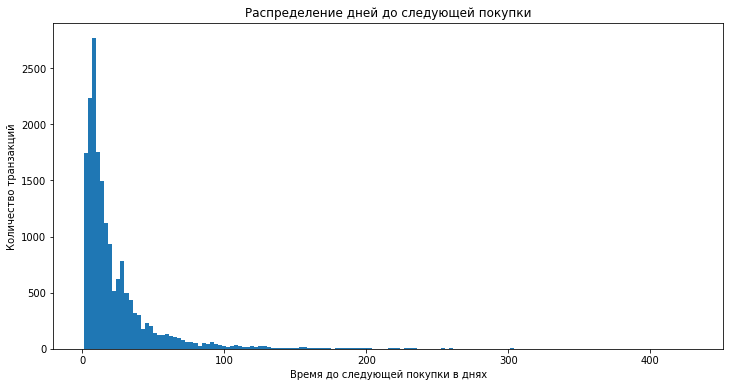

95%-й квантиль, дней: 74
75%-й квантиль, дней: 28
Медиана, дней: 13
25%-й квантиль, дней: 7


In [60]:
# посмотрим распределение признака future_interval в транзакциях начиная с 4-й и кроме последней
metrika = client_trans_df['future_interval'].loc[client_trans_df['last_trans_number'] != 1]
plt.figure(figsize=(12, 6))
plt.hist(metrika, bins = 150)
plt.xlabel('Время до следующей покупки в днях')
plt.ylabel('Количество транзакций')
plt.title('Распределение дней до следующей покупки')
plt.show()
print ('95%-й квантиль, дней: ' + str(int(np.quantile(metrika, .95))))
print ('75%-й квантиль, дней: ' + str(int(np.quantile(metrika, .75))))
print ('Медиана, дней: ' + str(int(np.quantile(metrika, .5))))
print ('25%-й квантиль, дней: ' + str(int(np.quantile(metrika, .25))))


### Соберем датасет по клиентам, чтобы посмотреть на распределение признака cum_mean_intervals

In [78]:
# оставим только необходимые колонки
client_df = trans_df.loc[:, ['cum_mean_intervals', 'client_ID', 'trans_number', 'last_trans_number']]
print('Всего транзакций: ' + str(client_df.shape[0]))
client_df.head()

Всего транзакций: 31737


,cum_mean_intervals,client_ID,trans_number,last_trans_number
0,0.000000,90,1,26
1,14.000000,90,2,25
2,10.500000,90,3,24
3,9.333333,90,4,23
4,8.250000,90,5,22


In [80]:
# чтобы получить датасет по клиентам, достаточно взять только их последнюю транзакцию, т.к. признаки в датасете накопительные
# т.е. признак по клиенту = признаку на дату последней транзакции по клиенту
client_df['condition'] = 1
client_df = client_df.loc[(client_df.last_trans_number == 1) & (client_df.trans_number >= 4), :] # отфильтруем клиентов с 4 и более транзакциями
client_df.drop(['condition'], axis=1, inplace=True)
print('Всего клиентов: ' + str(client_df.shape[0]))
client_df.head()

Всего клиентов: 2483


,cum_mean_intervals,client_ID,trans_number,last_trans_number
25,11.160000,90,26,1
31,58.200000,325,6,1
40,40.285714,4613,8,1
46,34.800000,8217,6,1
64,42.583333,19509,13,1


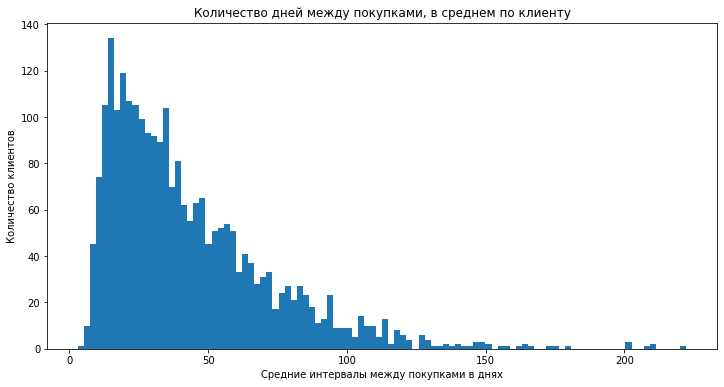

95%-й квантиль, дней: 100
75%-й квантиль, дней: 57
Медиана, дней: 35
Мода, дней: 31
Среднее, дней: 43
25%-й квантиль, дней: 21


In [82]:
# посмотрим распределение признака cum_mean_intervals в датасете по клиентам (т.е. ср. интервал между покупками клиентов)
metrika = client_df['cum_mean_intervals']
plt.figure(figsize=(12, 6))
plt.hist(metrika, bins = 100)
plt.xlabel('Средние интервалы между покупками в днях')
plt.ylabel('Количество клиентов')
plt.title('Количество дней между покупками, в среднем по клиенту')
plt.show()
print ('95%-й квантиль, дней: ' + str(int(np.quantile(metrika, .95))))
print ('75%-й квантиль, дней: ' + str(int(np.quantile(metrika, .75))))
print ('Медиана, дней: ' + str(int(np.quantile(metrika, .5))))
print ('Мода, дней: ' + str(int(scipy.stats.mode(metrika)[0][0])))
print ('Среднее, дней: ' + str(int(np.mean(metrika))))
print ('25%-й квантиль, дней: ' + str(int(np.quantile(metrika, .25))))


### Cделаем кластеризацию на основе данных по октябрь 2017 год

Для кластеризации нужно сгруппировать данные по клиентам, взяв последнюю транзакцию по каждому клиенту (как мы делали это ранее). Однако в данном случае мы берем не весь датасет, а только его наиболее раннюю часть.

In [90]:
# исключим колонки, которые не будут участвовать в кластеризации
cluster_cols = ['client_ID', 'order_date', 'last_trans_number',
                'trans_number', 'product_number', 'cat_number', 
                'cum_mean_intervals', 'cum_mean_cat_intervals', 'cum_mean_prod_intervals']

clust_df_train = trans_df.loc[list(trans_df.order_date <= datetime.datetime.strptime('2017-10-01', '%Y-%m-%d')), 
                    cluster_cols]
clust_df_train.head()

,client_ID,order_date,last_trans_number,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals
26,325,2017-02-09,6,1,1.0,1.0,0.000000,0.0,0.0
27,325,2017-03-06,5,2,1.0,1.5,25.000000,12.5,0.0
28,325,2017-05-18,4,3,1.0,1.0,49.000000,0.0,0.0
29,325,2017-06-26,3,4,1.0,1.0,45.666667,0.0,0.0
47,14923,2017-09-28,2,1,1.0,1.0,0.000000,0.0,0.0


In [91]:
# для обучения необходимо взять последнюю транзакцию из тех, которые попали в обучающий набор
# последняя транзакция в обучающем наборе не всегда будет иметь признак last_trans_number = 1
# определим, какое минимальное значение last_trans_number будет иметь последняя транзакция в обучающем наборе
cont = clust_df_train[['last_trans_number', 'client_ID']].groupby(['client_ID']).min().reset_index()
cont.rename(columns = {'last_trans_number': 'condition'}, inplace=True) 

#оставим только последние транзакции клиентов на конец октября 2017 года
clust_df_train = clust_df_train.merge(cont, on=['client_ID'])
clust_df_train = clust_df_train.loc[(clust_df_train.last_trans_number == clust_df_train.condition) & \
                                    (clust_df_train.trans_number >=3) & \
                                    (clust_df_train.last_trans_number !=1), :]
clust_df_train.drop(['condition'], axis=1, inplace=True)
clust_df_train.head()

,client_ID,order_date,last_trans_number,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals
3,325,2017-06-26,3,4,1.000000,1.00,45.666667,0.000000,0.000000
13,19509,2017-09-28,5,9,1.000000,3.25,33.125000,94.433333,0.000000
38,217500,2017-09-08,3,4,1.000000,1.00,81.333333,0.000000,0.000000
45,219173,2017-09-15,2,7,1.000000,1.00,11.833333,0.000000,0.000000
61,277406,2017-08-31,4,10,1.333333,2.00,23.222222,75.833333,6.666667


In [92]:
# стандартизируем данные для того, чтобы провести кластеризацию
SC = StandardScaler()
clust_sc = SC.fit_transform(clust_df_train.drop(['client_ID', 
                                                   'order_date', 'last_trans_number'], axis=1))
clust_sc = pd.DataFrame(clust_sc, index = clust_df_train.client_ID, 
                        columns=clust_df_train.drop(['client_ID', 'order_date', 'last_trans_number'], axis=1).columns)

clust_sc.head()

,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals
client_ID,,,,,,
325,-0.499152,-0.328127,-0.692210,0.100017,-0.795759,-0.272058
19509,0.550467,-0.328127,0.712353,-0.403503,1.051429,-0.272058
217500,-0.499152,-0.328127,-0.692210,1.531955,-0.795759,-0.272058
219173,0.130619,-0.328127,-0.692210,-1.258317,-0.795759,-0.272058
277406,0.760391,0.876085,-0.067960,-0.801078,0.687599,-0.085154


In [93]:
# остановимся на небольшом количестве кластеров, например, 3
K = 3
KM = KMeans(n_clusters=K, max_iter = 500, random_state=100)
KM.fit(clust_sc)
cluster_lab = pd.DataFrame([clust_sc.index, KM.labels_], index = ['client_ID', 'cluster']).T
cluster_lab['cluster'].value_counts().std()

84.01785524517987

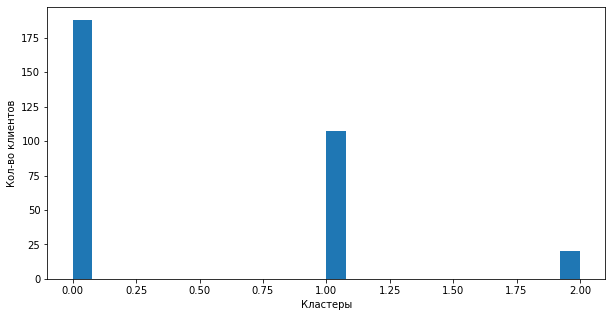

In [94]:
# посмотрим на количество объектов в кластерах
plt.figure(figsize=(10, 5))
plt.hist(cluster_lab['cluster'], bins=26)
plt.xlabel('Кластеры')
plt.ylabel('Кол-во клиентов')
plt.show()

In [97]:
# кластеры, состоящие менее чем из 10 клиентов, объеденим в один
# в случае последней версии данного файла это неактуально
small_clusters = np.argwhere(np.bincount(KM.labels_) <= 10).reshape(sum(np.bincount(KM.labels_) <= 10), )
cluster_lab['cluster'].loc[np.isin(KM.labels_, small_clusters)] = -1

client_trans_df_ = client_trans_df.merge(cluster_lab, how='right', on = ['client_ID'])

client_trans_df_.shape

(2475, 5)

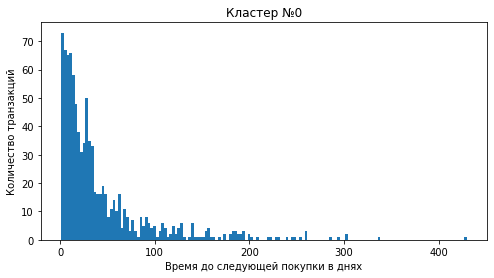

95%-й квантиль, дней: 154
75%-й квантиль, дней: 49
Медиана, дней: 25
25%-й квантиль, дней: 10


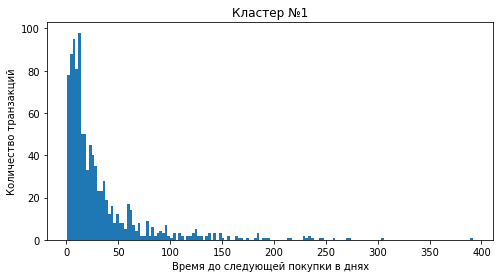

95%-й квантиль, дней: 123
75%-й квантиль, дней: 36
Медиана, дней: 17
25%-й квантиль, дней: 8


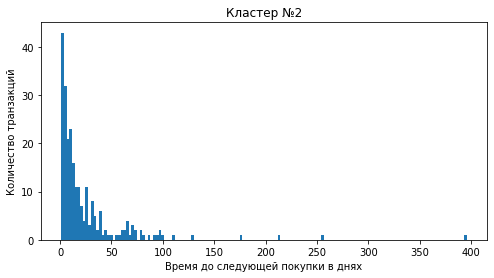

95%-й квантиль, дней: 81
75%-й квантиль, дней: 28
Медиана, дней: 12
25%-й квантиль, дней: 5


In [98]:
### Посмотрим распределение признака future_interval для кластеров 
metrika_ = []
quant_ = []
for ind, i in enumerate(cluster_lab['cluster'].unique()):
    metrika_.append(client_trans_df_['future_interval'].loc[(client_trans_df_.cluster == i) & 
                                                          (client_trans_df_.last_trans_number != 1)])
    plt.figure(figsize=(8, 4))
    plt.hist(metrika_[ind], bins = 150)
    plt.xlabel('Время до следующей покупки в днях')
    plt.ylabel('Количество транзакций')
    plt.title('Кластер №' + str(i))
    plt.show()

    quant_.append([i, np.quantile(metrika_[ind], .90)])
    print ('95%-й квантиль, дней: ' + str(int(np.quantile(metrika_[ind], .95))))
    print ('75%-й квантиль, дней: ' + str(int(np.quantile(metrika_[ind], .75))))
    print ('Медиана, дней: ' + str(int(np.quantile(metrika_[ind], .5))))
    print ('25%-й квантиль, дней: ' + str(int(np.quantile(metrika_[ind], .25))))

### Проверим, являются ли наши кластеры полезными?
Значимы ли сдвиги в распределении каждого из кластеров и общей выборки?

In [99]:
# выведем кол-во объектов в кластере и p_value
res_ = []
for ind, i in enumerate(cluster_lab['cluster'].unique()):
    res_.append(list([i]) + list([len(metrika_[ind])]) + list([np.mean(metrika_[ind]) - np.mean(metrika)]) + \
                list(stats.mannwhitneyu(metrika_[ind], metrika)))
    
    print (str(len(metrika_[ind])) + ' - ' + str(stats.mannwhitneyu(metrika_[ind], metrika)[1].round(4)))

908 - 0.0
1013 - 0.0
239 - 0.0


In [102]:
# сделаем поправку на множественность гипотез, применим к-т Холма 
hypothises = pd.DataFrame(res_, columns = ['cluster', 'counts', 'mean_diff', 'stats', 'p_value'])
hypothises = hypothises.loc[hypothises.counts > 10]

reject, p_corrected, a1, a2 = multipletests(hypothises.p_value, 
                                            alpha = 0.05, 
                                            method = 'holm') 
hypothises['p_corrected'] = p_corrected
hypothises['reject'] = reject
hypothises[hypothises.reject == True]
hypothises.sort_values(['counts'], ascending = False)

,cluster,counts,mean_diff,stats,p_value,p_corrected,reject
1,1,1013,-10.546229,763571.0,1.052232e-74,3.156697e-74,True
0,0,908,-1.281251,860623.0,2.210417e-26,2.210417e-26,True
2,2,239,-18.444394,133621.5,3.599211e-45,7.198423e-45,True


Сдвиг по отношению к среднему в выборке является значимым для каждого кластера.

### Для клиентов 2018 года предскажем их кластер 

In [106]:
# сформируем выборку, начиная с ноября 2017 года (для предсказания кластера и последующего обучения модели)
clust_df_predict = trans_df.loc[list(trans_df.order_date > datetime.datetime.strptime('2017-10-01', '%Y-%m-%d')), 
                    cluster_cols]
clust_df_predict.head()

,client_ID,order_date,last_trans_number,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals
0,90,2018-01-31,26,1,1.00,1.000000,0.000000,0.000000,0.0
1,90,2018-02-14,25,2,1.00,1.000000,14.000000,0.000000,0.0
2,90,2018-02-21,24,3,1.00,1.333333,10.500000,2.333333,0.0
3,90,2018-02-28,23,4,1.00,2.000000,9.333333,14.000000,0.0
4,90,2018-03-05,22,5,1.25,2.500000,8.250000,7.125000,3.0


In [107]:
# надо взять транзакции, начиная с 4-й
clust_df_predict = clust_df_predict.loc[(clust_df_predict.trans_number >=4), :]
clust_df_predict.head()

,client_ID,order_date,last_trans_number,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals
3,90,2018-02-28,23,4,1.00,2.0,9.333333,14.000000,0.0
4,90,2018-03-05,22,5,1.25,2.5,8.250000,7.125000,3.0
5,90,2018-03-13,21,6,1.00,1.0,8.200000,0.000000,0.0
6,90,2018-03-21,20,7,1.00,2.0,8.166667,8.000000,0.0
7,90,2018-03-27,19,8,3.00,4.0,7.857143,13.666667,17.0


In [108]:
# стандартизируем данные на новой выборке 
index = clust_df_predict.client_ID
columns = clust_df_predict.drop(['client_ID', 'order_date', 'last_trans_number'], axis=1).columns
clust_df_predict_sc = SC.transform(clust_df_predict.drop(['client_ID', 'order_date', 'last_trans_number'], axis=1))
clust_df_predict_sc = pd.DataFrame(clust_df_predict_sc, index = index, 
                                    columns = columns).reset_index()

clust_df_predict_sc.head()

,client_ID,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals
0,90,-0.499152,-0.328127,-0.067960,-1.358686,-0.521908,-0.272058
1,90,-0.289228,0.575032,0.244165,-1.402180,-0.656388,-0.187951
2,90,-0.079305,-0.328127,-0.692210,-1.404187,-0.795759,-0.272058
3,90,0.130619,-0.328127,-0.067960,-1.405525,-0.639273,-0.272058
4,90,0.340543,6.897143,1.180541,-1.417952,-0.528428,0.204547


Мы обучали кластеризацию, используя накопительные признаки на дату последней известной транзакции клиента. Значит, мы можем спрогнозировать кластер в датасете по транзакциям на дату каждой транзакции с точки зрения имеющейся истории по клиенту на момент транзакции. 

Получается, что у клиента со временем может меняться кластер (но ведь клиенты могут менять паттерны поведения, значит, это нормально). Чем больше истории по клиенту, тем сложнее ему поменять свой кластер (так как данные накопительные и каждая последующая строка будет иметь меньший вес в общей истории).

In [109]:
# спрогнозируем кластер клиента в текущей транзакции
cluster_labels = KM.predict(clust_df_predict_sc.drop(['client_ID'], axis=1))
clust_df_predict['cluster'] = cluster_labels
clust_df_predict.head(10)

,client_ID,order_date,last_trans_number,trans_number,product_number,cat_number,cum_mean_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals,cluster
3,90,2018-02-28,23,4,1.000000,2.000000,9.333333,14.000000,0.000000,0
4,90,2018-03-05,22,5,1.250000,2.500000,8.250000,7.125000,3.000000,1
5,90,2018-03-13,21,6,1.000000,1.000000,8.200000,0.000000,0.000000,0
6,90,2018-03-21,20,7,1.000000,2.000000,8.166667,8.000000,0.000000,0
7,90,2018-03-27,19,8,3.000000,4.000000,7.857143,13.666667,17.000000,2
8,90,2018-04-04,18,9,1.166667,3.000000,7.875000,24.986111,8.166667,1
9,90,2018-04-08,17,10,1.000000,2.000000,7.444444,11.500000,0.000000,1
10,90,2018-04-18,16,11,1.000000,3.500000,7.700000,25.875000,0.000000,1
11,90,2018-04-24,15,12,1.500000,4.000000,7.545455,31.900000,25.000000,1
12,90,2018-06-09,14,13,2.000000,3.666667,10.750000,22.388889,31.333333,2


### Соберем датасет по транзакциям для обучения

In [110]:
# посмотрим на имеющиеся колонки
data.columns

Index(['client_ID', 'order_date', 'sum_rub', 'sum_cnt', 'trans_number',
       'cat_number', 'product_number', 'interval1', 'interval2', 'interval3',
       'cum_mean_intervals', 'cat_intervals', 'cum_mean_cat_intervals',
       'prod_intervals', 'cum_mean_prod_intervals', 'price_rub',
       'future_interval', 'max_trans_num', 'last_trans_number', 'weights'],
      dtype='object')

In [111]:
trans_df_train = trans_df.merge(clust_df_predict[['trans_number', 
                                                  'client_ID', 
                                                  'cluster']], on = ['trans_number', 
                                                                     'client_ID'], how = 'right')
trans_df_train.head()

,client_ID,trans_number,order_date,interval1,interval2,interval3,future_interval,cum_mean_intervals,max_trans_num,last_trans_number,...,cat_number,product_number,cat_intervals,prod_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals,price_rub,sum_cnt,sum_rub,cluster
0,90,4,2018-02-28,7.0,7.0,14.0,5.0,9.333333,26,23,...,2.0,1.00,14.0,0.0,14.000000,0.0,113.000,1,113,0
1,90,5,2018-03-05,5.0,7.0,7.0,8.0,8.250000,26,22,...,2.5,1.25,5.5,3.0,7.125000,3.0,84.625,22,856,1
2,90,6,2018-03-13,8.0,5.0,7.0,8.0,8.200000,26,21,...,1.0,1.00,0.0,0.0,0.000000,0.0,118.500,2,237,0
3,90,7,2018-03-21,8.0,8.0,5.0,6.0,8.166667,26,20,...,2.0,1.00,8.0,0.0,8.000000,0.0,40.000,1,40,0
4,90,8,2018-03-27,6.0,8.0,8.0,8.0,7.857143,26,19,...,4.0,3.00,22.0,22.0,13.666667,17.0,295.000,1,295,2


In [112]:
# конвертируем признак кластера в бинарные
dummies_ = pd.get_dummies(trans_df_train['cluster'], drop_first='First')
dummies_.columns = [str(int(i)) + ('_') for i in dummies_.columns]
trans_df_train = pd.concat([trans_df_train, dummies_], axis=1)
trans_df_train.head()

,client_ID,trans_number,order_date,interval1,interval2,interval3,future_interval,cum_mean_intervals,max_trans_num,last_trans_number,...,cat_intervals,prod_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals,price_rub,sum_cnt,sum_rub,cluster,1_,2_
0,90,4,2018-02-28,7.0,7.0,14.0,5.0,9.333333,26,23,...,14.0,0.0,14.000000,0.0,113.000,1,113,0,0,0
1,90,5,2018-03-05,5.0,7.0,7.0,8.0,8.250000,26,22,...,5.5,3.0,7.125000,3.0,84.625,22,856,1,1,0
2,90,6,2018-03-13,8.0,5.0,7.0,8.0,8.200000,26,21,...,0.0,0.0,0.000000,0.0,118.500,2,237,0,0,0
3,90,7,2018-03-21,8.0,8.0,5.0,6.0,8.166667,26,20,...,8.0,0.0,8.000000,0.0,40.000,1,40,0,0,0
4,90,8,2018-03-27,6.0,8.0,8.0,8.0,7.857143,26,19,...,22.0,22.0,13.666667,17.0,295.000,1,295,2,0,1


In [113]:
# удалим признаки, которые не будем использовать в обучении
drop_cols = ['order_date', 'max_trans_num']

trans_df_train = trans_df_train.drop(drop_cols, axis=1)
trans_df_train.head()

,client_ID,trans_number,interval1,interval2,interval3,future_interval,cum_mean_intervals,last_trans_number,weights,cat_number,...,cat_intervals,prod_intervals,cum_mean_cat_intervals,cum_mean_prod_intervals,price_rub,sum_cnt,sum_rub,cluster,1_,2_
0,90,4,7.0,7.0,14.0,5.0,9.333333,23,1.130435,2.0,...,14.0,0.0,14.000000,0.0,113.000,1,113,0,0,0
1,90,5,5.0,7.0,7.0,8.0,8.250000,22,1.181818,2.5,...,5.5,3.0,7.125000,3.0,84.625,22,856,1,1,0
2,90,6,8.0,5.0,7.0,8.0,8.200000,21,1.238095,1.0,...,0.0,0.0,0.000000,0.0,118.500,2,237,0,0,0
3,90,7,8.0,8.0,5.0,6.0,8.166667,20,1.300000,2.0,...,8.0,0.0,8.000000,0.0,40.000,1,40,0,0,0
4,90,8,6.0,8.0,8.0,8.0,7.857143,19,1.368421,4.0,...,22.0,22.0,13.666667,17.0,295.000,1,295,2,0,1


### Определим целевую функцию

In [115]:
# целевая функция равна 1, если у клиента это дейстительно последняя транзакция и клиент не возвращался более N дней
# где N определеяется пороговым значением для каждого кластера, которое мы установили выше
# порог возьмем как 25% квантиль распределения интервалов между покупками

trans_df_train['y'] = 0

for i in range(K):
    trans_df_train.loc[(trans_df_train.future_interval > np.quantile(metrika_[i], .25)) & \
                     (trans_df_train.cluster == i) & \
                     (trans_df_train.last_trans_number == 1), 'y'] = 1
    
trans_df_train.y.value_counts()

0    17325
1     1879
Name: y, dtype: int64

In [140]:
# разделим выборку на обучающую и тестовую
X = trans_df_train.drop(['y'], axis=1)
y = trans_df_train.loc[:, ['y']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.25,
                                                      random_state=128)

In [141]:
# в итоговом обучающем наборе останутся только num_cols и bin_cols колонки:
num_cols = [ #'cat_intervals',
             'cat_number',
             'cum_mean_cat_intervals',
             'cum_mean_intervals',
             'cum_mean_prod_intervals',
             'interval1',
             'interval2',
             'interval3',
             #'prod_intervals',
             'product_number',
             'future_interval',
             'trans_number',
            'price_rub',
            'sum_cnt',
            'sum_rub'
           ] 

num_cols_2 = ['future_interval']

weights = X_train['weights']

In [142]:
bin_cols = dummies_.columns.to_list() # категории бинарные
bin_cols = []

### Построим модель

In [143]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [144]:
# определим признаки, которые не будут участвовать в обучении
col_drop = []

In [145]:
# построим случайный лес
RF = RandomForestClassifier(random_state=100, n_estimators=1500, max_features='auto', class_weight = 'balanced')
RF.fit(X_train[num_cols + bin_cols], y_train['y'], sample_weight = weights)
pred_train = predictions_RF = [row[1] for row in RF.predict_proba(X_train[num_cols + bin_cols])]
pred_test = predictions_RF = [row[1] for row in RF.predict_proba(X_valid[num_cols + bin_cols])]
metric_train = metrics.roc_auc_score(y_train['y'], pred_train)
metric_test = metrics.roc_auc_score(y_valid['y'], pred_test)

print (metric_test.round(4))

0.9598


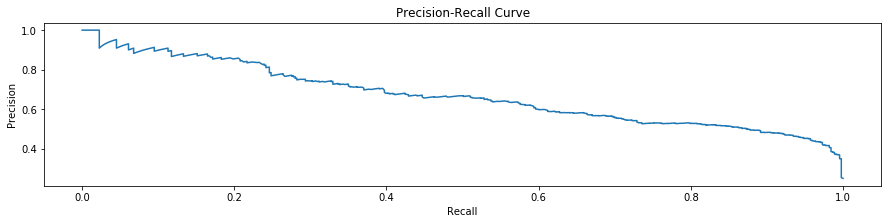

In [146]:
# построим кривую полноты/точности для случайного леса
pr, rec, thr = metrics.precision_recall_curve(y_valid['y'], pred_test)

plt.figure(figsize=(15, 3))
plt.plot(rec, pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [147]:
# посчитаем метрики точности, полноты и F1-меру
predicts_RF = np.array([0] * len(pred_test))
predicts_RF[np.array(pred_test) > 0.05] = 1

print('Точность: ' + str(metrics.precision_score(y_valid['y'], predicts_RF).round(4)))
print('Полнота: ' + str(metrics.recall_score(y_valid['y'], predicts_RF).round(4)))
print('F1 - мера: ' + str(metrics.f1_score(y_valid['y'], predicts_RF).round(4)))

pd.DataFrame(metrics.confusion_matrix(y_valid['y'], predicts_RF),
            columns = ['predict_0', 'predict_1'],
            index = ['true_0', 'true_1'])

Точность: 0.3467
Полнота: 0.9977
F1 - мера: 0.5146


,predict_0,predict_1
true_0,3525,833
true_1,1,442


In [148]:
# посмотрим важность признаков для случайного леса
imp = pd.DataFrame([RF.feature_importances_, X_train[num_cols + bin_cols].drop(col_drop, axis=1).columns.to_list()], 
                   index = ['imp', 'feat']).T
imp.sort_values(['imp'], ascending=False).head(30)

,imp,feat
8,0.47902,future_interval
2,0.0871719,cum_mean_intervals
4,0.0839197,interval1
9,0.0606994,trans_number
1,0.0410642,cum_mean_cat_intervals
5,0.039906,interval2
10,0.0377172,price_rub
6,0.0373598,interval3
12,0.0353078,sum_rub
0,0.0321769,cat_number


In [149]:
all_df = pd.concat([X_valid, y_valid], axis=1)
all_df['y_predict_proba'] = pred_test
all_df.head()

,client_ID,trans_number,interval1,interval2,interval3,future_interval,cum_mean_intervals,last_trans_number,weights,cat_number,...,cum_mean_cat_intervals,cum_mean_prod_intervals,price_rub,sum_cnt,sum_rub,cluster,1_,2_,y,y_predict_proba
14915,91495454,21,6.0,14.0,13.0,14.0,12.700000,6,4.333333,4.6,...,30.893333,0.0,81.666667,8,594,1,1,0,0,0.001333
12097,91342142,10,12.0,127.0,7.0,73.0,22.666667,1,10.000000,1.0,...,0.000000,0.0,152.200000,8,924,0,0,0,1,0.378667
12184,91348077,5,39.0,32.0,28.0,34.0,25.500000,5,1.800000,2.5,...,61.000000,35.5,207.500000,2,415,1,1,0,0,0.034667
3946,1178880,6,4.0,12.0,25.0,16.0,11.600000,12,1.416667,1.0,...,0.000000,0.0,199.000000,1,199,0,0,0,0,0.000000
10483,91250080,7,13.0,23.0,23.0,32.0,23.833333,7,1.857143,1.0,...,0.000000,0.0,633.000000,1,633,0,0,0,0,0.076000


### Анализ результатов модели

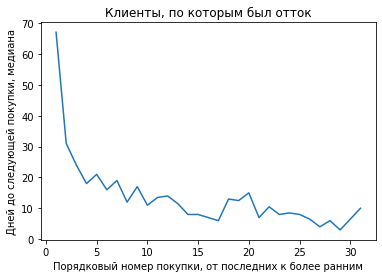

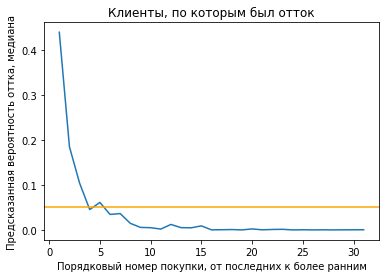

In [157]:
# построим график и посмотрим на некоторые закономерности
cond = all_df.loc[all_df.y == 1, 'client_ID']
df_ = all_df.loc[all_df.client_ID.isin(cond), ['client_ID', 'last_trans_number', 'future_interval']]
pivot_df = pd.pivot_table(df_, 
               values='future_interval', 
               index=['client_ID'],columns=['last_trans_number'], 
               aggfunc=np.median)

df_prob = all_df.loc[all_df.client_ID.isin(cond), ['client_ID', 'last_trans_number', 'y_predict_proba']]
pivot_df_prob = pd.pivot_table(df_prob, 
               values='y_predict_proba', 
               index=['client_ID'],columns=['last_trans_number'], 
               aggfunc=np.median)

predict_prob_number_X = pivot_df_prob.mean(axis=0, skipna=True).index.to_list()
last_trans_number_X = pivot_df.median(axis=0, skipna=True).index.to_list()
predict_prob_number_Y = pivot_df_prob.mean(axis=0, skipna=True)
last_trans_number_Y = pivot_df.median(axis=0, skipna=True)

plt.plot(last_trans_number_X, last_trans_number_Y)
plt.title('Клиенты, по которым был отток')
plt.xlabel('Порядковый номер покупки, от последних к более ранним')
plt.ylabel('Дней до следующей покупки, медиана')
plt.show()

plt.plot(predict_prob_number_X, predict_prob_number_Y)
plt.axhline(y=0.05, color='orange', linestyle='-')
plt.title('Клиенты, по которым был отток')
plt.xlabel('Порядковый номер покупки, от последних к более ранним')
plt.ylabel('Предсказанная вероятность оттка, медиана')
plt.show()

По первому графику видно, что у клиентов с оттоком интервал между покупками увеличивается перед непосредственно оттоком. Т.е. отток - это процесс постепенного снижения покупательской активности.

По второму графику все, что выше оранжевой линии, мы предсказали как отток. Это не всегда были действительно последние покупки клиентов (на графике последние покупки - это X = 1), но все же преимущественно последние (X < 5). Это говорит о том, те транзакции, где модель ошиблась, были хоть и не последними, но одними из последних.
